In [81]:
import lhapdf
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad

In [95]:
A = lhapdf.mkPDF("CT14nlo") 
p = lhapdf.mkPDF("CT14nlo") 
fname = 'pp'
sqrts = 5020
print(p.xfxQ2(21, .1, 1e4))


LHAPDF 6.4.0 loading /home/weiyaoke/.local/share/LHAPDF/CT14nlo/CT14nlo_0000.dat
CT14nlo PDF set, member #0, version 1; LHAPDF ID = 13100
LHAPDF 6.4.0 loading /home/weiyaoke/.local/share/LHAPDF/CT14nlo/CT14nlo_0000.dat
CT14nlo PDF set, member #0, version 1; LHAPDF ID = 13100
0.8824773939516205


[]

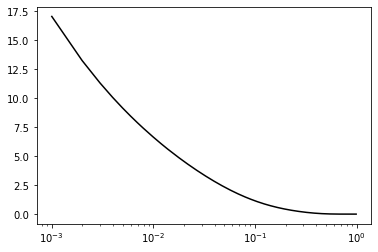

In [96]:
x = np.linspace(0.001,.99,1000)
y0 = np.array([p.xfxQ(21, ix, 10) for ix in x])
plt.plot(x,y0,'k')
#plt.plot(x,y2,'r')
plt.semilogx()
#plt.ylim(0,2)

In [97]:
# partonic Xsection: dsigma/domega
def alphas(Q2):
    return p.alphasQ2(Q2)
def dSigma_dOmega_qqbar2QQbar(s,cos,Q2):
    t = -s/2.*(1-cos)
    u = -s-t
    a2 = alphas(Q2)**2
    return a2/(9.*s)*(t**2+u**2)/s**2
def dSigma_dOmega_qQ2qQ(s,cos,Q2):
    t = -s/2.*(1-cos)
    u = -s-t
    a2 = alphas(Q2)**2
    return a2/(9.*s)*(s**2+u**2)/t**2
def dSigma_dOmega_qqbar2qqbar(s,cos,Q2):
    t = -s/2.*(1-cos)
    u = -s-t
    a2 = alphas(Q2)**2
    return a2/(9.*s)*( (t**2+u**2)/s**2 + (s**2+u**2)/t**2 - 2*u**2/(3*s*t) )
def dSigma_dOmega_qq2qq(s,cos,Q2):
    t = -s/2.*(1-cos)
    u = -s-t
    a2 = alphas(Q2)**2
    return a2/(9.*s)*( (t**2+s**2)/u**2 + (s**2+u**2)/t**2 - 2*s**2/(3*u*t) )
def dSigma_dOmega_qqbar2gg(s,cos,Q2):
    t = -s/2.*(1-cos)
    u = -s-t
    a2 = alphas(Q2)**2
    return 8.*a2/(27.*s)*(t**2+u**2)*(1./(t*u) - 9./4./s**2)
def dSigma_dOmega_qg2qg(s,cos,Q2):
    t = -s/2.*(1-cos)
    u = -s-t
    a2 = alphas(Q2)**2
    return a2/(9.*s)*(s**2+u**2)*(-1./(s*u) + 9./4./t**2)
def dSigma_dOmega_gg2qqbar(s,cos,Q2):
    t = -s/2.*(1-cos)
    u = -s-t
    a2 = alphas(Q2)**2
    return a2/(24.*s)*(t**2+u**2)*(1./(t*u) - 9./4./s**2)
def dSigma_dOmega_gg2gg(s,cos,Q2):
    t = -s/2.*(1-cos)
    u = -s-t
    a2 = alphas(Q2)**2
    return 9*a2/(8.*s)*(3. - u*t/s**2 - s*u/t**2 - s*t/u**2)

In [214]:
# LO jet production at eta=0
@np.vectorize
def dsigma_dpT2_deta_pp2g(pT2, eta, s, muF=1.0, muR=1.0):
    Q2F = pT2*muF
    Q2R = pT2*muR
    def df_dcostheta(rapCM):
        costheta = np.tanh(rapCM)
        x1x2 = 4*pT2/s/(1-costheta**2)
        x1overx2 = np.exp(2*(eta - .5*np.log((1.+costheta)/(1.-costheta))))
        shat = x1x2*s
        x1 = np.sqrt(x1x2*x1overx2)
        x2 = np.sqrt(x1x2/x1overx2)
        if x1>.999 or x2>=.999 or x1<1e-7 or x2<1e-7:
            return 0.
        else:
            Jacobian = 4 / shat
            gg2gg = np.max([0.,p.xfxQ(21, x1, Q2F) * A.xfxQ(21, x2, Q2F)]) * dSigma_dOmega_gg2gg(shat, costheta, Q2R) 
            qg2qg = np.sum([ np.max([0.,p.xfxQ(pid, x1, Q2F) * A.xfxQ(21, x2, Q2F)])
                           + np.max([0.,p.xfxQ(21, x1, Q2F) * A.xfxQ(pid, x2, Q2F)])\
                             for pid in [-5,-4,-3,-2,-1,1,2,3,4,5]])\
                           * dSigma_dOmega_qg2qg(shat, costheta, Q2R) 
            qq2gg = np.sum( [np.max([0., p.xfxQ(pid, x1, Q2F) * A.xfxQ(-pid, x2, Q2F) ])
                           + np.max([0., p.xfxQ(-pid, x1, Q2F) * A.xfxQ(pid, x2, Q2F) ])\
                             for pid in [1,2,3,4,5]] )\
                    * dSigma_dOmega_qqbar2gg(shat, costheta, Q2R) 
            summed = gg2gg + qg2qg + qq2gg
            return summed*Jacobian* 2*np.pi
    res, err = quad(df_dcostheta, -10,10, epsabs=1e-20, epsrel=1e-5, limit=300)
    print(res, err)
    return res

@np.vectorize
def dsigma_dpT2_deta_pp2q(pT2, eta, s, qid, muF=1.0, muR=1.0):
    Q2F = pT2*muF
    Q2R = pT2*muR
    qids = [1,2,3,4,5]
    diff_qids = [1,2,3,4,5]
    diff_qids.remove(np.abs(qid) )
    alldiff_qids = [-5,-4,-3,-2,-1,1,2,3,4,5]
    alldiff_qids.remove(qid)
    def df_dcostheta(rapCM):
        costheta = np.tanh(rapCM)
        x1x2 = 4*pT2/s/(1-costheta**2)
        x1overx2 = np.exp(2*(eta - .5*np.log((1.+costheta)/(1.-costheta))))
        shat = x1x2*s
        x1 = np.sqrt(x1x2*x1overx2)
        x2 = np.sqrt(x1x2/x1overx2)
        if x1>.999 or x2>=.999 or x1<1e-7 or x2<1e-7:
            return 0.
        else:
            Jacobian = 4 / shat
            qqbar2QQbar = np.sum([ np.max([0., p.xfxQ(pid, x1, Q2F) * A.xfxQ(-pid, x2, Q2F) ])
                                 + np.max([0., p.xfxQ(-pid, x1, Q2F) * A.xfxQ(pid, x2, Q2F) ])
                                 for pid in diff_qids ]
                          )* dSigma_dOmega_qqbar2QQbar(shat, costheta, Q2R) 
            qQ2qQ = np.sum( [np.max([0., p.xfxQ(qid, x1, Q2F) * A.xfxQ(pid, x2, Q2F) ])
                           + np.max([0., p.xfxQ(pid, x1, Q2F) * A.xfxQ(qid, x2, Q2F) ])
                             for pid in alldiff_qids])\
                  * dSigma_dOmega_qQ2qQ(shat, costheta, Q2R) 
            qq2qq = np.max([0., p.xfxQ(qid, x1, Q2F) * A.xfxQ(qid, x2, Q2F)]) \
                        * dSigma_dOmega_qq2qq(shat, costheta, Q2R) 
            qqbar2qqbar = (np.max([0.,p.xfxQ(qid, x1, Q2F) * A.xfxQ(-qid, x2, Q2F)])
                         + np.max([0.,p.xfxQ(-qid, x1, Q2F) * A.xfxQ(qid, x2, Q2F)]) )\
                        * dSigma_dOmega_qqbar2qqbar(shat, costheta, Q2R) 
            gg2qqbar = np.max([0., p.xfxQ(21, x1, Q2F) * A.xfxQ(21, x2, Q2F)]) \
                        * dSigma_dOmega_gg2qqbar(shat, costheta, Q2R) 
            qg2qg = ( np.max([0.,p.xfxQ(qid, x1, Q2F) * A.xfxQ(21, x2, Q2F) ])
                     + np.max([0.,p.xfxQ(21, x1, Q2F) * A.xfxQ(qid, x2, Q2F) ]) )\
                    * dSigma_dOmega_qg2qg(shat, costheta, Q2R) 
            summed = qqbar2QQbar + qQ2qQ + qq2qq + qqbar2qqbar + gg2qqbar + qg2qg
            return summed*Jacobian* 2*np.pi 
    res, err = quad(df_dcostheta, -10,10, epsabs=1e-20, epsrel=1e-5, limit=300)
    #print(res, err)
    return res

In [217]:
GeVm2_to_mb = 1/5.076**2/100*1000
pT = 20
dsigma_dpT2_deta_pp2q(pT**2, 0, 5020**2, 1)*2*pT * GeVm2_to_mb

0.0005180663091090912

In [86]:
mu = 1
s = sqrts**2
ymax = .6
N = 5
dy = 2*ymax/N
Y = np.linspace(-ymax+dy/2., ymax-dy/2., N)
pT = np.exp(np.linspace(np.log(20),np.log(sqrts/2),30))
ng = np.sum([dsigma_dpT2_deta_pp2g(pT**2, eta=y, s=s, muR=mu, muF=mu) for y in Y], axis=0)*dy/2/ymax
nd = np.sum([dsigma_dpT2_deta_pp2q(pT**2, eta=y, s=s, qid=1, muR=mu, muF=mu) for y in Y], axis=0)*dy/2/ymax
nu = np.sum([dsigma_dpT2_deta_pp2q(pT**2, eta=y, s=s, qid=2, muR=mu, muF=mu) for y in Y], axis=0)*dy/2/ymax
ns = np.sum([dsigma_dpT2_deta_pp2q(pT**2, eta=y, s=s, qid=3, muR=mu, muF=mu) for y in Y], axis=0)*dy/2/ymax
nc = np.sum([dsigma_dpT2_deta_pp2q(pT**2, eta=y, s=s, qid=4, muR=mu, muF=mu) for y in Y], axis=0)*dy/2/ymax
nb = np.sum([dsigma_dpT2_deta_pp2q(pT**2, eta=y, s=s, qid=5, muR=mu, muF=mu) for y in Y], axis=0)*dy/2/ymax
ndbar = np.sum([dsigma_dpT2_deta_pp2q(pT**2, eta=y, s=s, qid=-1, muR=mu, muF=mu) for y in Y], axis=0)*dy/2/ymax
nubar = np.sum([dsigma_dpT2_deta_pp2q(pT**2, eta=y, s=s, qid=-2, muR=mu, muF=mu) for y in Y], axis=0)*dy/2/ymax



pp->g
pp->g
pp->g
pp->g
pp->g
pp->g
pp->g
pp->g
pp->g
pp->g
pp->g
pp->g
pp->g
pp->g
pp->g
pp->g
pp->g
pp->g
pp->g
pp->g
pp->g
pp->g
pp->g
pp->g
pp->g
pp->g
pp->g
pp->g
pp->g
pp->g
pp->g
pp->g
pp->g
pp->g
pp->g
pp->g
pp->g
pp->g
pp->g
pp->g
pp->g
pp->g
pp->g
pp->g
pp->g
pp->g
pp->g
pp->g
pp->g
pp->g
pp->g
pp->g
pp->g
pp->g
pp->g
pp->g
pp->g
pp->g
pp->g
pp->g
pp->g
pp->g
pp->g
pp->g
pp->g
pp->g
pp->g
pp->g
pp->g
pp->g
pp->g
pp->g
pp->g
pp->g
pp->g
pp->g
pp->g
pp->g
pp->g
pp->g
pp->g
pp->g
pp->g
pp->g
pp->g
pp->g
pp->g
pp->g
pp->g
pp->g
pp->g
pp->g
pp->g
pp->g
pp->g
pp->g
pp->g
pp->g
pp->g
pp->g
pp->g
pp->g
pp->g
pp->g
pp->g
pp->g
pp->g
pp->g
pp->g
pp->g
pp->g
pp->g
pp->g
pp->g
pp->g
pp->g
pp->g
pp->g
pp->g
pp->g
pp->g
pp->g
pp->g
pp->g
pp->g
pp->g
pp->g
pp->g
pp->g
pp->g
pp->g
pp->g
pp->g
pp->g
pp->g
pp->g
pp->g
pp->g
pp->g
pp->g
pp->g
pp->g
pp->g
pp->g
pp->g
pp->g
pp->g
pp->g


/tmp/ipykernel_600530/2821963634.py:29: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  res, err = quad(df_dcostheta, -10,10, epsabs=1e-20, epsrel=1e-5, limit=300)


pp->g
pp->g
pp->g
pp->g
pp->g
pp->g
pp->g
pp->q: 1
pp->q: 1
pp->q: 1
pp->q: 1
pp->q: 1
pp->q: 1
pp->q: 1
pp->q: 1
pp->q: 1
pp->q: 1
pp->q: 1
pp->q: 1
pp->q: 1
pp->q: 1
pp->q: 1
pp->q: 1
pp->q: 1
pp->q: 1
pp->q: 1
pp->q: 1
pp->q: 1
pp->q: 1
pp->q: 1
pp->q: 1
pp->q: 1
pp->q: 1
pp->q: 1
pp->q: 1
pp->q: 1
pp->q: 1
pp->q: 1
pp->q: 1
pp->q: 1
pp->q: 1
pp->q: 1
pp->q: 1
pp->q: 1
pp->q: 1
pp->q: 1
pp->q: 1
pp->q: 1
pp->q: 1
pp->q: 1
pp->q: 1
pp->q: 1
pp->q: 1
pp->q: 1
pp->q: 1
pp->q: 1
pp->q: 1
pp->q: 1
pp->q: 1
pp->q: 1
pp->q: 1
pp->q: 1
pp->q: 1
pp->q: 1
pp->q: 1
pp->q: 1
pp->q: 1
pp->q: 1
pp->q: 1
pp->q: 1
pp->q: 1
pp->q: 1
pp->q: 1
pp->q: 1
pp->q: 1
pp->q: 1
pp->q: 1
pp->q: 1
pp->q: 1
pp->q: 1
pp->q: 1
pp->q: 1
pp->q: 1
pp->q: 1
pp->q: 1
pp->q: 1
pp->q: 1
pp->q: 1
pp->q: 1
pp->q: 1
pp->q: 1
pp->q: 1
pp->q: 1
pp->q: 1
pp->q: 1
pp->q: 1
pp->q: 1
pp->q: 1
pp->q: 1
pp->q: 1
pp->q: 1
pp->q: 1
pp->q: 1
pp->q: 1
pp->q: 1
pp->q: 1
pp->q: 1
pp->q: 1
pp->q: 1
pp->q: 1
pp->q: 1
pp->q: 1
pp->q: 1
pp->

/tmp/ipykernel_600530/2821963634.py:74: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  res, err = quad(df_dcostheta, -10,10, epsabs=1e-20, epsrel=1e-5, limit=300)


pp->q: 2
pp->q: 2
pp->q: 2
pp->q: 2
pp->q: 2
pp->q: 2
pp->q: 2
pp->q: 2
pp->q: 2
pp->q: 2
pp->q: 2
pp->q: 2
pp->q: 2
pp->q: 2
pp->q: 2
pp->q: 2
pp->q: 2
pp->q: 2
pp->q: 2
pp->q: 2
pp->q: 2
pp->q: 2
pp->q: 2
pp->q: 2
pp->q: 2
pp->q: 2
pp->q: 2
pp->q: 2
pp->q: 2
pp->q: 2
pp->q: 2
pp->q: 2
pp->q: 2
pp->q: 2
pp->q: 2
pp->q: 2
pp->q: 2
pp->q: 2
pp->q: 2
pp->q: 2
pp->q: 2
pp->q: 2
pp->q: 2
pp->q: 2
pp->q: 2
pp->q: 2
pp->q: 2
pp->q: 2
pp->q: 2
pp->q: 2
pp->q: 2
pp->q: 2
pp->q: 2
pp->q: 2
pp->q: 2
pp->q: 2
pp->q: 2
pp->q: 2
pp->q: 2
pp->q: 2
pp->q: 2
pp->q: 2
pp->q: 2
pp->q: 2
pp->q: 2
pp->q: 2
pp->q: 2
pp->q: 2
pp->q: 2
pp->q: 2
pp->q: 2
pp->q: 2
pp->q: 2
pp->q: 2
pp->q: 2
pp->q: 2
pp->q: 2
pp->q: 2
pp->q: 2
pp->q: 2
pp->q: 2
pp->q: 2
pp->q: 2
pp->q: 2
pp->q: 2
pp->q: 2
pp->q: 2
pp->q: 2
pp->q: 2
pp->q: 2
pp->q: 2
pp->q: 2
pp->q: 2
pp->q: 2
pp->q: 2
pp->q: 2
pp->q: 2
pp->q: 2
pp->q: 2
pp->q: 2
pp->q: 2
pp->q: 2
pp->q: 2
pp->q: 2
pp->q: 2
pp->q: 2
pp->q: 2
pp->q: 2
pp->q: 2
pp->q: 2
pp->q: 2
p

pp->q: -2
pp->q: -2
pp->q: -2
pp->q: -2
pp->q: -2
pp->q: -2
pp->q: -2
pp->q: -2
pp->q: -2
pp->q: -2
pp->q: -2
pp->q: -2
pp->q: -2
pp->q: -2
pp->q: -2
pp->q: -2
pp->q: -2
pp->q: -2
pp->q: -2
pp->q: -2
pp->q: -2
pp->q: -2
pp->q: -2
pp->q: -2
pp->q: -2
pp->q: -2
pp->q: -2


In [89]:

with open("LO/{ss}/{fname}_mu{scale}_ALICE.dat".format(ss=sqrts, fname=fname, scale=mu),'w') as f:
    for ipT,g,d,u,s,c,b,dbar,ubar in zip(pT, ng, nd, nu, 
                                                  ns, nc, nb,
                                                  ndbar, nubar
                                                    ):
        print(g,d,u,s,c,b,dbar,ubar)
        f.write(("{:1.5e}\t"*9+'\n').format(ipT,g,d,u,s,c,b,dbar,ubar))


0.0005907389351293913 3.3222425990227625e-05 4.5213561668352855e-05 1.7125976719086238e-05 1.3901561497035565e-05 1.0231300546907486e-05 2.1588581407119613e-05 2.073933709212677e-05
0.00021874755754522696 1.3180975798136432e-05 1.8247230293599627e-05 6.497159576848185e-06 5.254387431349006e-06 3.887494558098427e-06 8.310725221538138e-06 7.946734984582622e-06
7.973654460045522e-05 5.170830122300167e-06 7.292238584912237e-06 2.426569244723601e-06 1.9532193592887343e-06 1.4506641664845392e-06 3.154190758479206e-06 3.0023572367318607e-06
2.860753101615054e-05 2.0055404830295887e-06 2.885318658292659e-06 8.919790573054505e-07 7.139391691632204e-07 5.316620101480648e-07 1.180023581054466e-06 1.11826413714416e-06
1.010110017552434e-05 7.690883878695145e-07 1.130316535637232e-06 3.226377020883443e-07 2.565435167341249e-07 1.9136596429474565e-07 4.3509807178128944e-07 4.1056462759421923e-07
3.508470833194428e-06 2.914974035921669e-07 4.3821922370667266e-07 1.147673610042832e-07 9.05781934089429